# NLP - Sentiment Analysis for IMDB Movie Reviews from scratch

## Load Data

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU")

2025-10-08 00:48:48.570536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-08 00:48:48.571324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-08 00:48:48.676518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 00:48:48.937413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using GPU


2025-10-08 00:48:58.197506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 00:48:58.340682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 00:48:58.340817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import os
import pandas as pd
from datasets import load_dataset

In [3]:
PATH_RAW_DATA = 'data/raw.csv'

In [4]:
if not os.path.exists(PATH_RAW_DATA):
    os.makedirs(os.path.dirname(PATH_RAW_DATA), exist_ok=True)
    dataset = load_dataset("imdb", split="train")
    df = pd.DataFrame(dataset)
    df.to_csv(PATH_RAW_DATA, index=False)
    print(f"Raw Data saved to {PATH_RAW_DATA}")
else:
    df = pd.read_csv(PATH_RAW_DATA)
    print(f"Raw Data loaded from {PATH_RAW_DATA}")

Raw Data loaded from data/raw.csv


In [5]:
print(df)

                                                    text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]


## Preprocess Data

In [6]:
import re
import string
import nltk
import spacy
import contractions
from unidecode import unidecode
from nltk.corpus import stopwords

In [7]:
PATH_PROCESSED_DATA = 'data/processed.csv'

In [8]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.9 MB/s eta 0:00:00:00:010:01m

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess_text(text, remove_stopwords=True, save_data=False):
    # Normalize encoding
    text = unidecode(text)

    # Lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove HTML tags and URLs
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove punctuation (keep ! and ? as they can carry sentiment)
    text = re.sub(r"[^a-zA-Z0-9!?']", " ", text)

    # Tokenize and Lemmatize using SpaCy
    doc = nlp(text)
    tokens = []
    for token in doc:
        lemma = token.lemma_.strip()
        if not lemma:
            continue
        if remove_stopwords and lemma in stop_words:
            continue
        tokens.append(lemma)

    # Remove extra whitespace and join back
    clean_text = " ".join(tokens)
    clean_text = re.sub(r"\s+", " ", clean_text).strip()
    clean_text = re.sub(r"[!?]{2,}", lambda m: m.group(0)[0], text)
    clean_text = re.sub(r"[^a-z0-9!?']", " ", text)

    if save_data:
        df['text'] = df['text'].apply(lambda x: preprocess_text(x, remove_stopwords))
        df.to_csv(PATH_PROCESSED_DATA, index=False)

    return clean_text

In [11]:
import tqdm

if not os.path.exists(PATH_PROCESSED_DATA):
    os.makedirs(os.path.dirname(PATH_PROCESSED_DATA), exist_ok=True)
    texts = df['text'].tolist()
    # texts = df['text'].tolist()[:20]
    # df = df.iloc[:20].copy()
    # Batch process with tqdm for progress bar
    processed_texts = []
    for doc in tqdm.tqdm(nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"])):
        tokens = [token.lemma_ for token in doc if token.lemma_ and token.lemma_ not in stop_words]
        clean_text = " ".join(tokens)
        processed_texts.append(clean_text)
    df['text'] = processed_texts
    df.to_csv(PATH_PROCESSED_DATA, index=False)
    print(f"Processed Data saved to {PATH_PROCESSED_DATA}")
else:
    df = pd.read_csv(PATH_PROCESSED_DATA)
    print(f"Processed Data loaded from {PATH_PROCESSED_DATA}")


Processed Data loaded from data/processed.csv


In [12]:
for i in df.index[:5]:
    print(f"Original: {df.loc[i, 'text']}")
    print(f"Processed: {preprocess_text(df.loc[i, 'text'], remove_stopwords=False)}\n")

Original: I rent I CURIOUS - yellow video store controversy surround first release 1967 . I also hear first seize U.S. custom ever try enter country , therefore fan film consider " controversial " I really see myself.<br /><br />The plot center around young swedish drama student name Lena want learn everything life . particular want focus attention make sort documentary average Swede think certain political issue Vietnam War race issue United States . ask politician ordinary denizen Stockholm opinion politic , sex drama teacher , classmate , marry men.<br /><br />What kill I I CURIOUS - YELLOW 40 year ago , consider pornographic . really , sex nudity scene far , even shoot like cheaply make porno . countryman mind find shocking , reality sex nudity major staple swedish cinema . even Ingmar Bergman , arguably answer good old boy John Ford , sex scene films.<br /><br />i commend filmmaker fact sex show film show artistic purpose rather shock people make money show pornographic theater Am

## TF-IDF

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)

In [15]:
tfidf_matrix = vectorizer.fit_transform(df['text'])

## Modelado

### Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = tfidf_matrix
y = df['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21562)

In [20]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (20000, 5000), Test shape: (5000, 5000)


### Creación del Modelo

In [21]:
# Using tensorflow, we will create a complete feedforward neural network from scratch
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

2025-10-08 03:23:27.714666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 03:23:27.717934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 03:23:27.717998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 03:23:30.759540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 03:23:30.760680: I external/local_xla/xla/stream_executor

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 648449 (2.47 MB)
Trainable params: 648449 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [26]:
history = model.fit(
    X_train.toarray(), y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20


2025-10-08 03:23:52.959768: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f18ba23fc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-08 03:23:52.959954: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-10-08 03:23:53.035987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-08 03:23:53.331989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1759893833.844624     512 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/500 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8216

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 32s 30ms/step - loss: 0.4033 - accuracy: 0.8220 - val_loss: 0.2737 - val_accuracy: 0.8890
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2330 - accuracy: 0.9123 - val_loss: 0.2871 - val_accuracy: 0.8780
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1709 - accuracy: 0.9356 - val_loss: 0.3142 - val_accuracy: 0.8773
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1204 - accuracy: 0.9601 - val_loss: 0.3587 - val_accuracy: 0.8733


In [27]:
import matplotlib.pyplot as plt

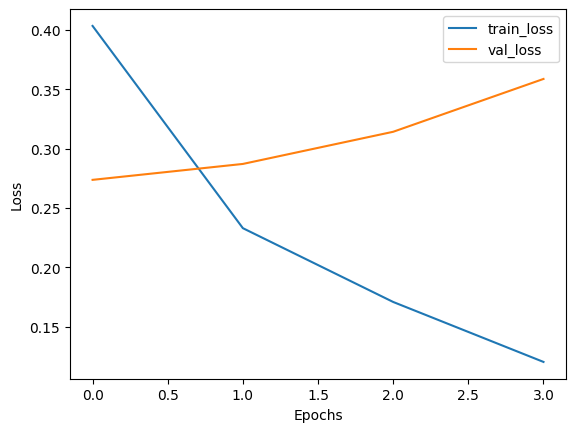

In [28]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

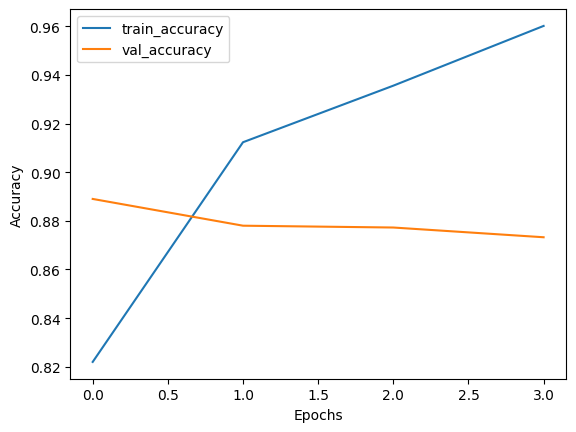

In [29]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# Try the model
# good_reviw = "This movie was fantastic! I really loved it and would watch it again."
# bad_review = "This movie was terrible. I hated it and will never watch it again."
# mixed_review = "The movie had some good moments but overall it was disappointing."
reviews = [
    "This is my new favorite movie",
    "This movie was fantastic! I really loved it and would watch it again.",
    "This movie was terrible. I hated it and will never watch it again.",
    "The movie had some good moments but overall it was disappointing.",
    "It fucking sucked, the worst thing my eyes ever saw."
]

In [42]:
def predict_review(review):
    review = preprocess_text(review, remove_stopwords=True)
    review_tfidf = vectorizer.transform([review])
    prediction = model.predict(review_tfidf.toarray())
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    return sentiment, prediction[0][0]

In [43]:
for review in reviews:
    sentiment, score = predict_review(review)
    print(f"Review: {review}\nPredicted sentiment: {sentiment} (score: {score:.4f})\n")

1/1 [==============================] - 0s 39ms/step
Review: This is my new favorite movie
Predicted sentiment: Positive (score: 0.8954)

1/1 [==============================] - 0s 37ms/step
Review: This movie was fantastic! I really loved it and would watch it again.
Predicted sentiment: Positive (score: 0.9129)

1/1 [==============================] - 0s 44ms/step
Review: This movie was terrible. I hated it and will never watch it again.
Predicted sentiment: Negative (score: 0.2989)

1/1 [==============================] - 0s 43ms/step
Review: The movie had some good moments but overall it was disappointing.
Predicted sentiment: Negative (score: 0.2984)

1/1 [==============================] - 0s 25ms/step
Review: It fucking sucked, the worst thing my eyes ever saw.
Predicted sentiment: Negative (score: 0.0537)

